# De-correlated MLPs on IRIS

## Imports

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

## Define MLP and HyperNetwork

In [94]:
class MLP(nn.Module):
    def __init__(self, input_dim, intermediate_dims, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims # list of ints
        self.output_dim = output_dim
        self.num_layers = len(intermediate_dims) + 1

        self.layers = []
        current_dim = input_dim
        next_dims = intermediate_dims + [output_dim]

        for i in range(self.num_layers):
            self.layers.append(nn.Linear(current_dim, next_dims[i]))
            current_dim = next_dims[i]

            if i != self.num_layers - 1:
                self.layers.append(nn.GELU())

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x, multi_stage=False):
        out = []
        if multi_stage:
            for layer in self.layers:
                x = layer(x)
                out.append(x)
        else:
            for layer in self.layers:
                x = layer(x)
            out = x

        return out


class HyperNetwork(nn.Module):
    def __init__(self, param_shapes, cond_emb_dim, num_conds, expansion_factor=4):
        """
        param_shapes: if the target network has N layers then
        [
            [ [w_1.shape[0], w_1.shape[1]], [b_1.shape[0]] ] --> layer 1
            ...
            [ [w_N.shape[0], w_N.shape[1]], [b_N.shape[0]] ] --> layer N
        ]
        """
        super().__init__()
        self.param_shapes = param_shapes
        self.cond_embs = nn.Embedding(num_conds, cond_emb_dim)
        self.expansion_factor = expansion_factor

        self.num_target_layers = len(param_shapes)
        self.cond_mapper = MLP(cond_emb_dim, [expansion_factor * cond_emb_dim for _ in range(self.num_target_layers-1)], expansion_factor*cond_emb_dim)

        self.weight_decoders = []
        self.bias_decoders = []

        for i in range(self.num_target_layers):
            output_param_shape = param_shapes[i][0][0] * param_shapes[i][0][1]
            decoder = nn.Linear(expansion_factor*cond_emb_dim, output_param_shape)
            self.weight_decoders.append(decoder)

            output_param_shape = param_shapes[i][1][0]
            decoder = nn.Linear(expansion_factor*cond_emb_dim, output_param_shape)
            self.bias_decoders.append(decoder)

        self.weight_decoders = nn.ModuleList(self.weight_decoders)
        self.bias_decoders = nn.ModuleList(self.bias_decoders)

    def forward(self, cond_ids):
        num_conds = len(cond_ids)
        cond_ids = torch.tensor(cond_ids).long()
        cond_embs = self.cond_embs(cond_ids)
        cond_embs_mapped = self.cond_mapper(cond_embs, multi_stage=True)

        weights, biases = [], []
        for i in range(self.num_target_layers):
            weights.append(self.weight_decoders[i](cond_embs_mapped[i]))
            biases.append(self.bias_decoders[i](cond_embs_mapped[i]))

        params = [ [weights[i].view(num_conds, *self.param_shapes[i][0]), biases[i]] for i in range(len(weights)) ]
        return params


## Test out HyperNetwork

In [95]:
param_shapes = [
    [ [128, 128], [128] ],
    [ [128, 128], [128] ],
]

hypernetwork = HyperNetwork(param_shapes, 8, 3)
cond_ids = [0, 1, 2]
predicted_params = hypernetwork(cond_ids)

c=0
for p in hypernetwork.parameters():
    c += p.numel()

print(c)

c = 0
m = MLP(128, [128], 128)
for p in m.parameters():
    c += p.numel()

print(c)

print(hypernetwork)
print(m)

1091160
33024
HyperNetwork(
  (cond_embs): Embedding(3, 8)
  (cond_mapper): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (weight_decoders): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=16384, bias=True)
  )
  (bias_decoders): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=128, bias=True)
  )
)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)


## Train and save multi-seed MLPs on IRIS

In [96]:
iris = load_iris()
X = iris.data
y = iris.target

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=42)

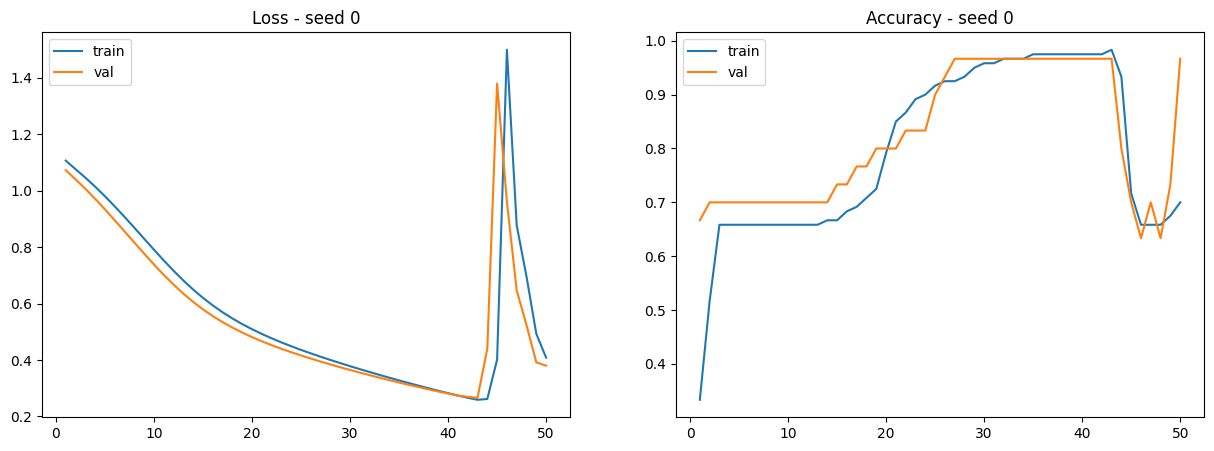

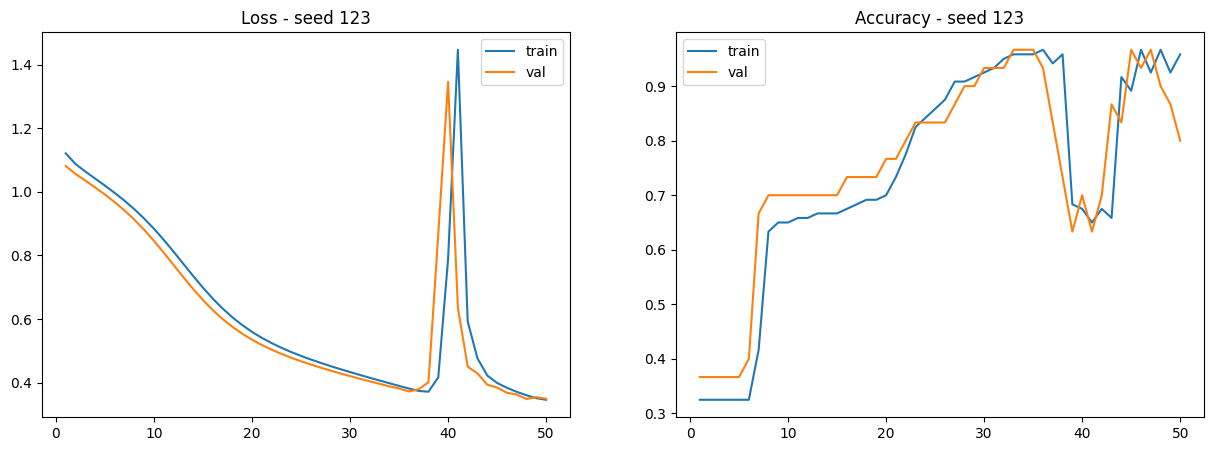

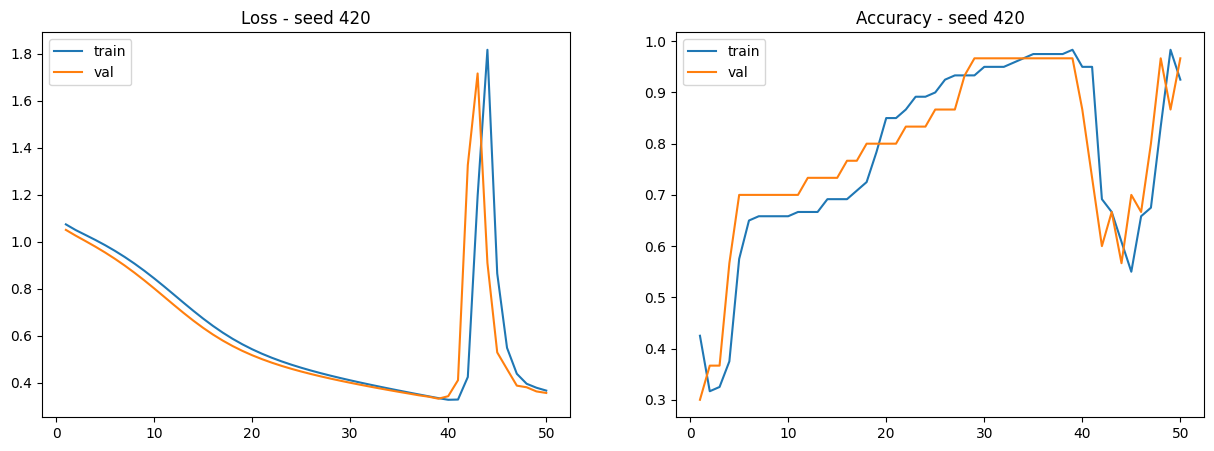

In [97]:
from tqdm import tqdm
import matplotlib.pyplot as plt

for seed in [0, 123, 420]:
    torch.manual_seed(seed)

    num_epochs = 50

    train_data = torch.from_numpy(X_train).float()
    train_labels = torch.from_numpy(y_train).long()

    val_data = torch.from_numpy(X_test).float()
    val_labels = torch.from_numpy(y_test).long()

    model = MLP(4, [16, 32], 3)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    store = {
        "train": {
            "loss": [],
            "accuracy": []
        },
        "val": {
            "loss": [],
            "accuracy": []
        }
    }

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        model.train()
        train_preds = model(train_data)
        train_loss = F.cross_entropy(train_preds, train_labels)
        train_accuracy = (train_preds.argmax(dim=1) == train_labels).float().mean()

        train_loss.backward()
        optimizer.step()

        model.eval()
        val_preds = model(val_data)
        val_loss = F.cross_entropy(val_preds, val_labels)
        val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean()


        store["train"]["loss"].append(train_loss.item())
        store["train"]["accuracy"].append(train_accuracy.item())

        store["val"]["loss"].append(val_loss.item())
        store["val"]["accuracy"].append(val_accuracy.item())

    torch.save(model.state_dict(), f"ckpt_50_ep_seed_{seed}.pt")

    epochs = [i for i in range(1, num_epochs+1)]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(epochs, store["train"]["loss"], label="train")
    axes[0].plot(epochs, store["val"]["loss"], label="val")
    axes[0].legend()
    axes[0].set_title(f"Loss - seed {seed}")

    axes[1].plot(epochs, store["train"]["accuracy"], label="train")
    axes[1].plot(epochs, store["val"]["accuracy"], label="val")
    axes[1].legend()
    axes[1].set_title(f"Accuracy - seed {seed}")

    plt.show()

## LMC on the multi-seed MLPs on IRIS

In [98]:
def interpolate_params(model_1, model_2, steps=10):
    alphas = np.linspace(0, 1, steps)

    result = {}

    for alpha in alphas:
        new_state_dict = {}

        for (k1, k2) in zip(model_1.keys(), model_2.keys()):
            # since the models are the same, k1 = k2
            assert k1 == k2, "Some problem in the state dicts."
            k = k1

            new_state_dict[k] = alpha * model_1[k] + (1 - alpha) * model_2[k]

        result[alpha] = new_state_dict

    return result


In [109]:
def test_lmc(s1, s2):

    model_1 = torch.load(f"ckpt_50_ep_seed_{s1}.pt", weights_only=True)
    model_2 = torch.load(f"ckpt_50_ep_seed_{s2}.pt", weights_only=True)

    model_int = interpolate_params(model_1, model_2)

    losses = []
    accuracies = []

    with torch.no_grad():
        for k in model_int.keys():
            model = MLP(4, [16, 32], 3)
            model.load_state_dict(model_int[k])

            model.eval()

            val_preds = model(val_data)
            val_loss = F.cross_entropy(val_preds, val_labels)
            val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean()

            losses.append(val_loss.item())
            accuracies.append(val_accuracy.item())

    alphas = list(model_int.keys())
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(alphas, losses, label="loss")
    axes[0].legend()
    axes[0].set_title(f"Loss over interpolations b/w Seed-{s1} and Seed-{s2}")
    axes[0].set_xlabel("alpha")
    axes[0].set_ylim([0.0, 1.0])

    axes[1].plot(alphas, accuracies, label="accuracies", c="r")
    axes[1].legend()
    axes[1].set_title(f"Accuracy over interpolations  b/w Seed-{s1} and Seed-{s2}")
    axes[1].set_xlabel("alpha")
    axes[1].set_ylim([0.0, 1.0])

    plt.show()


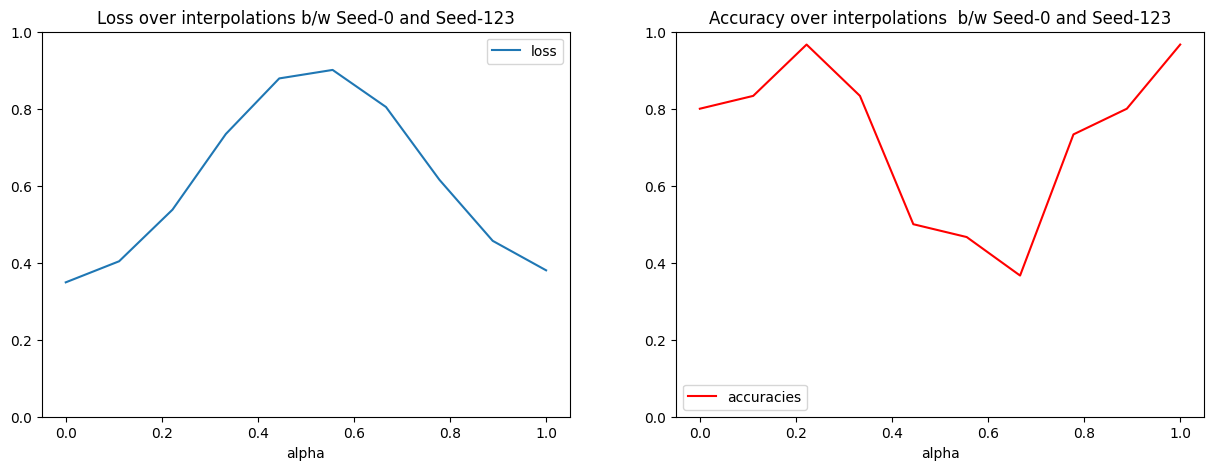

In [110]:
test_lmc(0, 123)

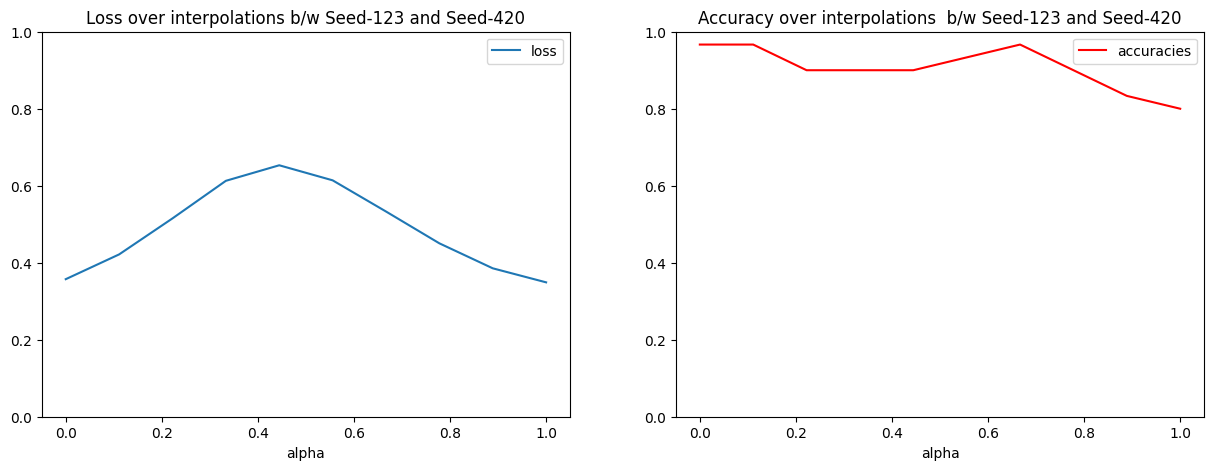

In [111]:
test_lmc(123, 420)

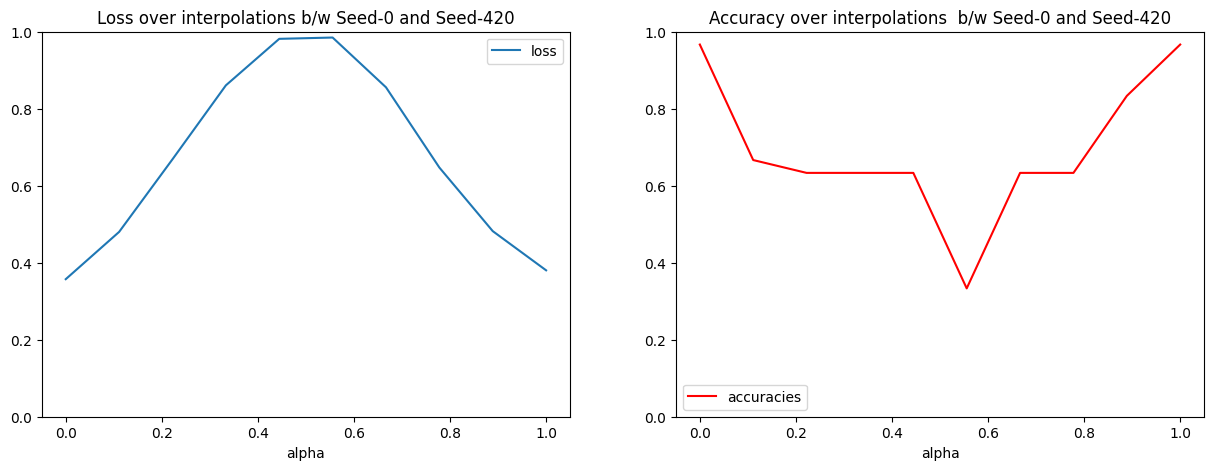

In [112]:
test_lmc(0, 420)

### Sanity checks

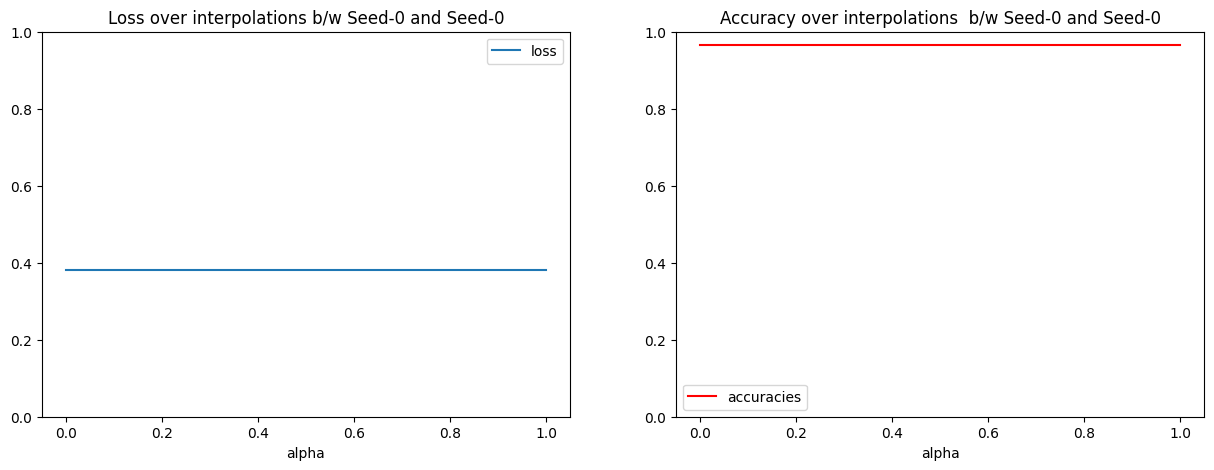

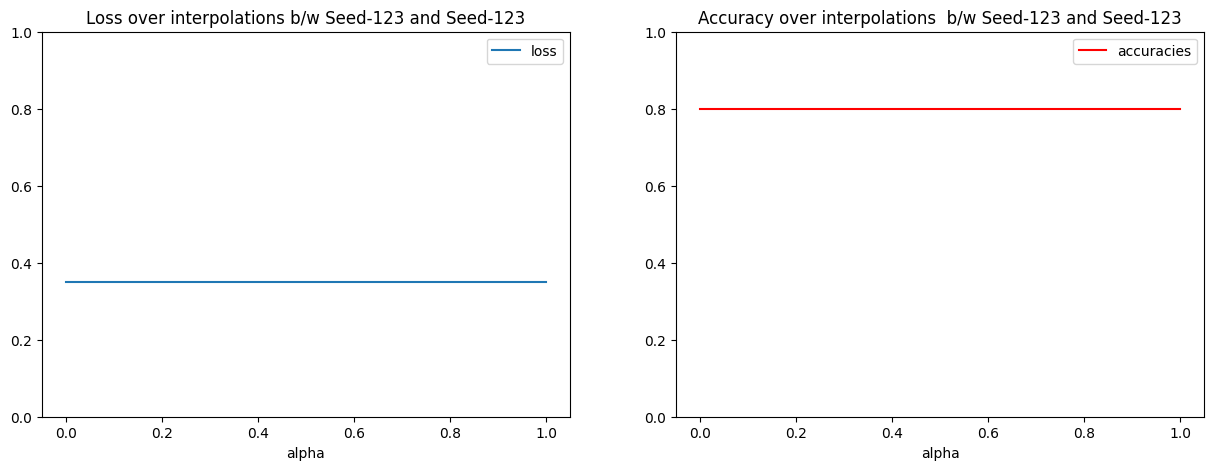

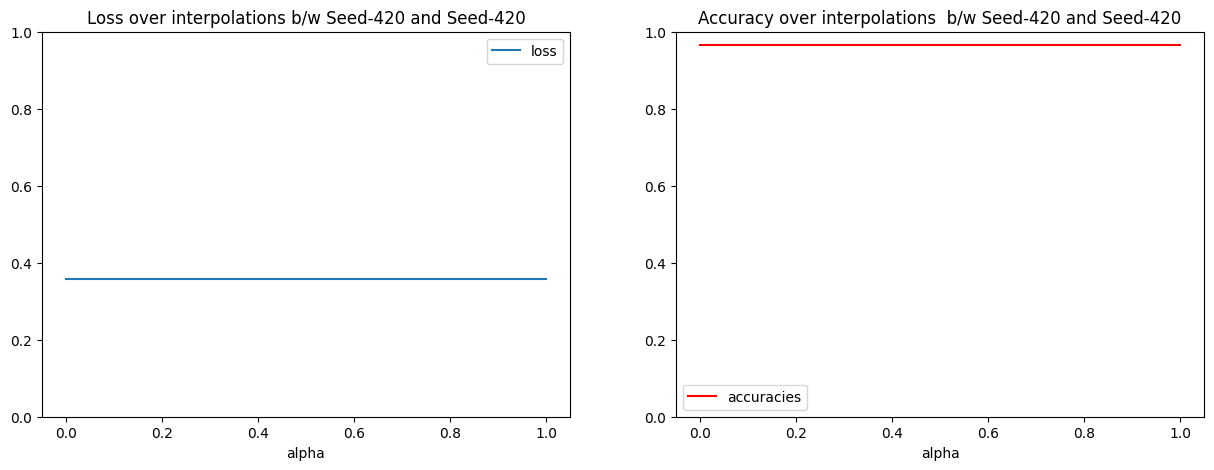

In [114]:
test_lmc(0, 0)
test_lmc(123, 123)
test_lmc(420, 420)

# Correlated MLPs (generated by HyperNetwork) on IRIS

TODO